# Example: Heavy-fluxonium initialization procedure
The lower frequency of Fluxonium causes it to relax to a mixed state, so it requires an active reset procedure. The coupling to a noisy resonator affected by photon loss provides the nonunitary operation needed to remove entropy from the fluxonium. This can be accomplished through the initialization procedure described in [this](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010) paper by Zhang et Al. 

In this procedure, the fluxonium starts out in a nearly mixed state between the first two energy levels, $\rho = \frac{1}{2}(|g\rangle \langle g| +|e\rangle \langle e|)\otimes |0\rangle \langle 0 |$. The firts four levels of the fluxonium are labeled with $g,e,f,h$ respectively, and the resonator Fock states are labeled with numbers. The transitions $|g0\rangle$ to $|h0\rangle$ and $|h0\rangle$ to $|e1\rangle$ are driven simulataneously for a period of 15$\mu$s. Throughout this process, photon loss in the resonator is causing the population of $|e1\rangle$ to transition to $|e0\rangle$.

In [92]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt

#experimental values borrowed from 
# https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010
qbt = scq.Fluxonium(
    EJ = 3.395,
    EC = .479,
    EL = .132,
    flux = .5, #flux frustration point
    cutoff = 110,
    truncated_dim = 10
)

osc = scq.Oscillator(
    E_osc=5.7,
    truncated_dim=8,
    id_str = 'resonator'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

hilbertspace.add_interaction(
    g_strength = .4,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

hilbertspace.generate_lookup()

In [93]:
np.diff(qbt.eigenvals())

array([0.01388156, 2.95091445, 0.25348453, 1.70547195, 0.01147044])

In [79]:
#get the index of a dressed state closed to a subsystem product state
def dressed_index(hilbertspace, *states):
    states_by_index = list(sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states]))
    return hilbertspace.dressed_index(list(zip(*states_by_index))[1])[0]

#wrap operator in identities and change to dressed eigenbasis
def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    evecs, = hilbertspace["evecs"]
    return op_id_wrap.transform(evecs)

total_truncation = 20

#truncate operators to desdired dimension
def truncate(operator):
    return qt.Qobj(operator[:total_truncation, : total_truncation])

#get the transition frequency between two states specified by dressed indices
def transition_frequency(s0, s1):
    return hilbertspace.energy_by_dressed_index(s1)-hilbertspace.energy_by_dressed_index(s0)

#Get the period of one Rabi cycle as a function of operator matrix element and drive strength
def drive_strength(s0, s1, period, drive_operator):
    return abs(2*np.pi/(period*drive_operator.data.toarray()[s0][s1]))

def rabi_period(s0, s1, Omega, drive_operator):
    return 2*np.pi/(Omega*drive_operator.data.toarray()[s0][s1])

In [57]:
#resonator drive operator
phi_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
phi_r_trunc = truncate(phi_r)

#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)
n_qbt_trunc = truncate(n_qbt)

The dressed eigenstates correspond closely to the bare product states since the coupling is weak. The `dressed_index` function matches a tensor product state to the corresponding dressed eigenstate.

In [58]:
g0 = dressed_index(hilbertspace, (qbt, 0 ),(osc, 0))
e0 = dressed_index(hilbertspace, (qbt, 1), (osc, 0))
h0 = dressed_index(hilbertspace, (qbt, 3), (osc, 0))
e1 = dressed_index(hilbertspace, (qbt, 1), (osc, 1))

In [216]:
sim_period = 2000
Omega1 = drive_strength(g0, h0, sim_period, phi_r)
Omega2 = drive_strength(h0, e1, sim_period, phi_r)
#g0 -> h0 transition
w1 = transition_frequency(h0, g0)
#h0 -> e1 transition
w2 = transition_frequency(e1, h0)

#drive amplitude as a function of time
def drive_coeff(t, args):
    return Omega1*np.cos(w1*t) + Omega2*np.cos(w2*t)

evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*2)
H_qbt_drive = [truncate(diag_dressed_hamiltonian),[phi_r_trunc, drive_coeff]]

In [217]:
states = [qt.basis(total_truncation,i) for i in [g0,e0,h0,e1]]

In [227]:
kappa = .003
f=.98

a_osc = truncate(basis_change(osc.annihilation_operator(), osc, hilbertspace))

#initial mixed state
thermal_state = .5*(states[0]*states[0].dag() + states[1]*states[1].dag())
tlist = np.linspace(0, 15000, 20000) #total time

In [228]:
result = qt.mesolve(
    H_qbt_drive, #hamiltonian
    thermal_state, #initial density matrix
    tlist,
    e_ops = [state * state.dag() for state in states], #expectation values
    c_ops = [np.sqrt(kappa)*a_osc], #collapse operators
)

Text(0, 0.5, 'population')

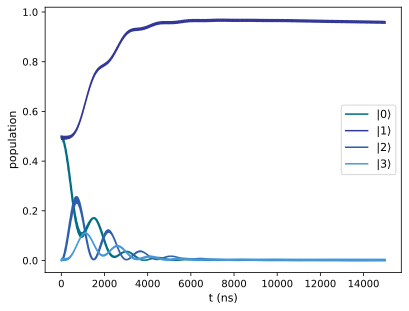

In [238]:
for i in range(4):
    plt.plot(tlist, result.expect[i], label=r"$|%u\rangle$"%(i))
plt.legend()
plt.xlabel("t (ns)")
plt.ylabel("population")

In [239]:
print("Fidelity:", result.expect[1][-1])

Fidelity: 0.9580618021980666
